<a href="https://colab.research.google.com/github/IvoandricGBC/Project-MLI-GBC/blob/main/distance_estimation_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [2]:
#Módulo B: Carga de Metadatos y Split
# Rutas
env_name = 'distance_estimation'
base_dir = f"/content/drive/My Drive/Colab Notebooks/{env_name}"
csv_path = os.path.join(base_dir, 'labels.csv')
img_dir  = os.path.join(base_dir, 'images')

# Leer CSV
df = pd.read_csv(csv_path)
# Resolver rutas de imagen
types = ['.png','.jpg','.jpeg']
def resolve_path(id_):
    for ext in types:
        p = os.path.join(img_dir, f"{id_}{ext}")
        if os.path.isfile(p): return p
    return None

df['img_path'] = df['ID'].astype(str).apply(resolve_path)
df = df.dropna(subset=['img_path']).reset_index(drop=True)
# Normalizar target
min_l, max_l = df['label'].min(), df['label'].max()
df['label_norm'] = (df['label'] - min_l) / (max_l - min_l)
# Split 80/20
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print('Train/Val sizes:', len(train_df), len(val_df))

Train/Val sizes: 400 100


In [3]:
# Módulo C: Dataset y Transformaciones Ajustadas
# Transformaciones suaves
def get_image_transform(train=True):
    ops = [transforms.Resize((224,224))]
    if train:
        ops += [transforms.RandomRotation(degrees=2)]
    ops += [
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]
    return transforms.Compose(ops)

class RegressionDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row.img_path).convert('RGB')
        img = self.transform(img)
        meta = torch.tensor([
            float(row['class']), float(row['Width']), float(row['location'])
        ], dtype=torch.float32)
        label = torch.tensor([row['label_norm']], dtype=torch.float32)
        return img, meta, label

In [4]:
#Módulo D: DataLoaders
train_ds = RegressionDataset(train_df, img_dir, get_image_transform(True))
val_ds   = RegressionDataset(val_df,   img_dir, get_image_transform(False))
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)

In [5]:
#Módulo E: Modelo Multimodal con BatchNorm y Dropout
class MultiModalRegressor(nn.Module):
    def __init__(self, img_dim=128, meta_dim=32):
        super().__init__()
        # CNN backbone
        cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        cnn.fc = nn.Linear(cnn.fc.in_features, img_dim)
        self.img_enc = cnn
        # Metadata MLP
        self.meta_enc = nn.Sequential(
            nn.Linear(3,64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64,meta_dim), nn.BatchNorm1d(meta_dim), nn.ReLU()
        )
        # Cabeza común
        self.head = nn.Sequential(
            nn.Linear(img_dim+meta_dim,64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64,1)
        )
    def forward(self, img, meta):
        e1 = self.img_enc(img)
        e2 = self.meta_enc(meta)
        x  = torch.cat([e1,e2],1)
        return self.head(x)

model = MultiModalRegressor().to(device)
print(model)

MultiModalRegressor(
  (img_enc): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [6]:
#Módulo F: Módulo F: Entrenamiento Inicial + Scheduler
# Funciones de loop
def train_epoch(mdl, loader, crit, opt):
    mdl.train(); running=0
    for imgs, metas, labels in loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        preds = mdl(imgs, metas)
        loss = crit(preds, labels)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item()*imgs.size(0)
    return running/len(loader.dataset)


def eval_epoch(mdl, loader, crit):
    mdl.eval(); running=0; ps, ls = [], []
    with torch.no_grad():
        for imgs, metas, labels in loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            preds=mdl(imgs,metas)
            running+=crit(preds,labels).item()*imgs.size(0)
            ps.append(preds.cpu().numpy()); ls.append(labels.cpu().numpy())
    p=np.concatenate(ps).flatten(); l=np.concatenate(ls).flatten()
    return (running/len(loader.dataset), mean_squared_error(l,p), mean_absolute_error(l,p), r2_score(l,p))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=2)

epochs = 20
for ep in range(1,epochs+1):
    tr_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss,mse,mae,r2 = eval_epoch(model, val_loader, criterion)
    scheduler.step(val_loss)
    print(f"Epoch {ep:02d} | Train: {tr_loss:.4f} | Val: {val_loss:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Epoch 01 | Train: 0.2145 | Val: 0.0982 | MAE: 0.2720 | R2: -1.0314
Epoch 02 | Train: 0.1395 | Val: 0.1083 | MAE: 0.3022 | R2: -1.2402
Epoch 03 | Train: 0.1122 | Val: 0.0175 | MAE: 0.1060 | R2: 0.6381
Epoch 04 | Train: 0.1190 | Val: 0.0436 | MAE: 0.1930 | R2: 0.0986
Epoch 05 | Train: 0.1090 | Val: 0.0168 | MAE: 0.1061 | R2: 0.6521
Epoch 06 | Train: 0.1072 | Val: 0.0216 | MAE: 0.1299 | R2: 0.5526
Epoch 07 | Train: 0.0848 | Val: 0.0104 | MAE: 0.0796 | R2: 0.7840
Epoch 08 | Train: 0.0865 | Val: 0.0202 | MAE: 0.1280 | R2: 0.5813
Epoch 09 | Train: 0.0793 | Val: 0.0064 | MAE: 0.0664 | R2: 0.8678
Epoch 10 | Train: 0.0806 | Val: 0.0090 | MAE: 0.0778 | R2: 0.8138
Epoch 11 | Train: 0.0744 | Val: 0.0063 | MAE: 0.0643 | R2: 0.8703
Epoch 12 | Train: 0.0661 | Val: 0.0091 | MAE: 0.0832 | R2: 0.8119
Epoch 13 | Train: 0.0623 | Val: 0.0038 | MAE: 0.0491 | R2: 0.9212
Epoch 14 | Train: 0.0647 | Val: 0.0044 | MAE: 0.0552 | R2: 0.9082
Epoch 15 | Train: 0.0661 | Val: 0.0163 | MAE: 0.1072 | R2: 0.6629
Epoch 16

In [7]:
#Módulo G: Fine-Tuning de layer4 con Batch=8
for name,param in model.img_enc.named_parameters():
    param.requires_grad = 'layer4' in name

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-6)
train_loader_ft = DataLoader(train_ds, batch_size=8, shuffle=True)

fine_epochs=10
for ep in range(1,fine_epochs+1):
    tr_loss = train_epoch(model, train_loader_ft, criterion, optimizer_ft)
    val_loss,mse,mae,r2 = eval_epoch(model, val_loader, criterion)
    print(f"FT {ep:02d} | Train: {tr_loss:.4f} | Val: {val_loss:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

FT 01 | Train: 0.0639 | Val: 0.0046 | MAE: 0.0578 | R2: 0.9054
FT 02 | Train: 0.0605 | Val: 0.0036 | MAE: 0.0501 | R2: 0.9263
FT 03 | Train: 0.0570 | Val: 0.0047 | MAE: 0.0533 | R2: 0.9037
FT 04 | Train: 0.0528 | Val: 0.0037 | MAE: 0.0479 | R2: 0.9227
FT 05 | Train: 0.0520 | Val: 0.0065 | MAE: 0.0627 | R2: 0.8662
FT 06 | Train: 0.0526 | Val: 0.0061 | MAE: 0.0615 | R2: 0.8743
FT 07 | Train: 0.0500 | Val: 0.0048 | MAE: 0.0534 | R2: 0.9014
FT 08 | Train: 0.0557 | Val: 0.0034 | MAE: 0.0474 | R2: 0.9291
FT 09 | Train: 0.0587 | Val: 0.0036 | MAE: 0.0472 | R2: 0.9260
FT 10 | Train: 0.0524 | Val: 0.0042 | MAE: 0.0514 | R2: 0.9126


In [8]:
#Módulo H: EarlyStopping Estricto
best_val, best_state = float('inf'), None
patience, trials = 2, 0
for ep in range(1,fine_epochs+1):
    tr_loss = train_epoch(model, train_loader_ft, criterion, optimizer_ft)
    val_loss,_,mae,r2 = eval_epoch(model, val_loader, criterion)
    print(f"ES {ep:02d} | Val: {val_loss:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    if val_loss < best_val:
        best_val, best_state, trials = val_loss, model.state_dict(), 0
    else:
        trials += 1
        if trials >= patience:
            print("EarlyStopping: deteniendo FT.")
            break
model.load_state_dict(best_state)

ES 01 | Val: 0.0053 | MAE: 0.0580 | R2: 0.8900
ES 02 | Val: 0.0033 | MAE: 0.0455 | R2: 0.9313
ES 03 | Val: 0.0044 | MAE: 0.0517 | R2: 0.9097
ES 04 | Val: 0.0034 | MAE: 0.0472 | R2: 0.9304
EarlyStopping: deteniendo FT.


<All keys matched successfully>

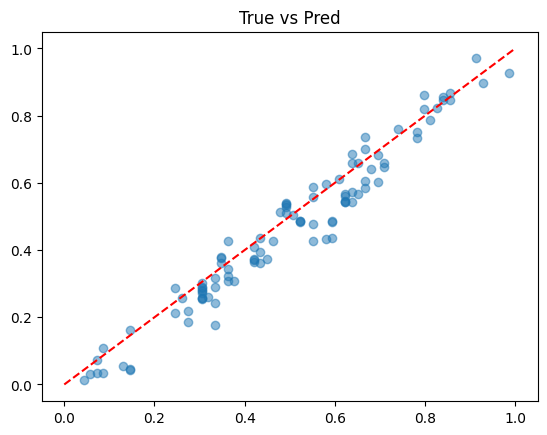

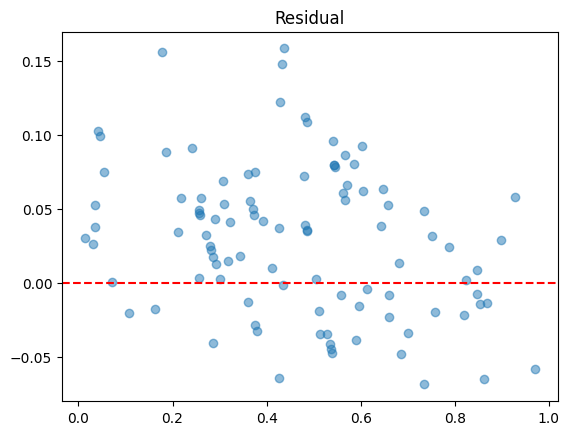

Bin 0.0-0.3: MAE=0.0458
Bin 0.3-0.6: MAE=0.0488
Bin 0.6-1.0: MAE=0.0455


In [9]:
#Módulo I: Visualizaciones de Validación
import matplotlib.pyplot as plt

# Scatter y residual global
model.eval(); ps, ls = [], []
with torch.no_grad():
    for imgs, metas, labels in val_loader:
        p = model(imgs.to(device), metas.to(device)).cpu().numpy().flatten()
        ps.extend(p); ls.extend(labels.numpy().flatten())
plt.figure(); plt.scatter(ls, ps, alpha=0.5); plt.plot([0,1],[0,1],'r--'); plt.title('True vs Pred'); plt.show()
res=np.array(ls)-np.array(ps)
plt.figure(); plt.scatter(ps, res, alpha=0.5); plt.axhline(0,linestyle='--',color='r'); plt.title('Residual'); plt.show()

# MAE por bin
bins = [0.0,0.3,0.6,1.0]
inds = np.digitize(ls, bins)-1
for i in range(len(bins)-1):
    mask = inds==i
    print(f"Bin {bins[i]}-{bins[i+1]}: MAE={mean_absolute_error(np.array(ls)[mask],np.array(ps)[mask]):.4f}")


In [10]:
#Módulo J: 5-Fold Cross-Validation con Pipeline Final
kf = KFold(5, shuffle=True, random_state=42)
cv_metrics=[]
for i,(ti,vi) in enumerate(kf.split(df)):
    df_tr, df_va = df.iloc[ti], df.iloc[vi]
    tr_ds = RegressionDataset(df_tr,img_dir,get_image_transform(True))
    va_ds = RegressionDataset(df_va,img_dir,get_image_transform(False))
    tr_ld = DataLoader(tr_ds,16,True); va_ld = DataLoader(va_ds,16,False)

    mdl = MultiModalRegressor().to(device)
    opt = optim.Adam(mdl.parameters(), lr=1e-4)
    crit=nn.MSELoss()
    sch = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.7, patience=2)

    # entrenamiento + FT + ES
    # inicial
    for ep in range(10):
        train_epoch(mdl, tr_ld, crit, opt)
        val_loss,_,_,_ = eval_epoch(mdl, va_ld, crit)
        sch.step(val_loss)
    # FT
    for name,param in mdl.img_enc.named_parameters(): param.requires_grad='layer4'in name
    opt_ft = optim.Adam(filter(lambda p:p.requires_grad, mdl.parameters()), lr=5e-6)
    best_val, trials = float('inf'),0
    for ep in range(10):
        train_epoch(mdl, DataLoader(tr_ds,8,True), crit, opt_ft)
        vl,_,mae,r2 = eval_epoch(mdl, va_ld, crit)
        if vl<best_val: best_val, best_state, trials = vl, mdl.state_dict(),0
        else:
            trials+=1
            if trials>=2: break
    mdl.load_state_dict(best_state)

    _,m,ma,r = eval_epoch(mdl, va_ld, crit)
    print(f"Fold{i+1}: MAE={ma:.4f}, R2={r:.4f}")
    cv_metrics.append((m,ma,r))

cv = np.array(cv_metrics)
print("CV mean MAE, R2:", cv[:,1].mean(), cv[:,2].mean())

Fold1: MAE=0.1625, R2=0.3844
Fold2: MAE=0.0815, R2=0.7700
Fold3: MAE=0.1177, R2=0.6087
Fold4: MAE=0.1074, R2=0.6911
Fold5: MAE=0.0530, R2=0.9142
CV mean MAE, R2: 0.10441621765494347 0.6736817479133606


In [11]:
# Ruta para guardar el mejor modelo
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/distance_estimation/best_model.pth"

# Guardar solo pesos
torch.save(model.state_dict(), MODEL_PATH)
print(f"Modelo guardado en {MODEL_PATH}")

# Para cargar más tarde:
# 1) Reconstruir arquitectura exacta
test_model = MultiModalRegressor().to(device)
# 2) Cargar pesos
test_model.load_state_dict(torch.load(MODEL_PATH))
# 3) Modo evaluación
test_model.eval()
print("Modelo cargado y listo para inferencia")

Modelo guardado en /content/drive/My Drive/Colab Notebooks/distance_estimation/best_model.pth
Modelo cargado y listo para inferencia


In [16]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms

# 1) Recrea df, img_dir y dispositivo
#    (asegúrate de ejecutar primero los módulos A y B del pipeline)
# 2) Vuelve a definir la clase MultiModalRegressor y cargar el modelo:

MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/distance_estimation/best_model.pth"
model = MultiModalRegressor().to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# 3) Toma 50 ejemplos aleatorios
sample_df = df.sample(n=50, random_state=42).reset_index(drop=True)

# 4) Transformación de inferencia
infer_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 5) Dataset de inferencia
class InferDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row.img_path).convert('RGB')
        img = self.transform(img)
        meta = torch.tensor([
            float(row['class']),
            float(row['Width']),
            float(row['location'])
        ], dtype=torch.float32)
        label = float(row['label_norm'])
        return img, meta, label, row['ID']

inf_ds = InferDataset(sample_df, img_dir, infer_transform)
inf_loader = DataLoader(inf_ds, batch_size=8, shuffle=False)

# 6) Inferencia y recopilación
results = []
with torch.no_grad():
    for imgs, metas, labels, ids in inf_loader:
        imgs = imgs.to(device)
        metas = metas.to(device)
        preds = model(imgs, metas).cpu().numpy().flatten()
        for img_id, true, pred in zip(ids, labels, preds):
            results.append({
                'ID': img_id,
                'label_norm_true': true,
                'label_norm_pred': float(pred),
                'error': abs(true - pred)
            })

res_df = pd.DataFrame(results)
# Después de recopilar true y pred en label_norm:

results = []
with torch.no_grad():
    for imgs, metas, labels, ids in inf_loader:
        imgs = imgs.to(device)
        metas = metas.to(device)
        preds_norm = model(imgs, metas).cpu().numpy().flatten()
        for img_id, true_norm, pred_norm in zip(ids, labels, preds_norm):
            # Desnormalizar
            true_orig = true_norm * (max_l - min_l) + min_l
            pred_orig = pred_norm * (max_l - min_l) + min_l
            results.append({
                'ID': img_id,
                'label_true': true_orig,
                'label_pred': pred_orig,
                'error': abs(true_orig - pred_orig)
            })

res_df = pd.DataFrame(results)
# Después de recopilar true y pred en label_norm:

results = []
with torch.no_grad():
    for imgs, metas, labels, ids in inf_loader:
        imgs = imgs.to(device)
        metas = metas.to(device)
        preds_norm = model(imgs, metas).cpu().numpy().flatten()
        for img_id, true_norm, pred_norm in zip(ids, labels, preds_norm):
            # Desnormalizar
            true_orig = true_norm * (max_l - min_l) + min_l
            pred_orig = pred_norm * (max_l - min_l) + min_l
            results.append({
                'ID': img_id,
                'label_true': true_orig,
                'label_pred': pred_orig,
                'error': abs(true_orig - pred_orig)
            })

res_df = pd.DataFrame(results)

# Después de recopilar true y pred en label_norm:

results = []
with torch.no_grad():
    for imgs, metas, labels, ids in inf_loader:
        imgs = imgs.to(device)
        metas = metas.to(device)
        preds_norm = model(imgs, metas).cpu().numpy().flatten()
        for img_id, true_norm, pred_norm in zip(ids, labels, preds_norm):
            # Desnormalizar
            true_orig = true_norm * (max_l - min_l) + min_l
            pred_orig = pred_norm * (max_l - min_l) + min_l
            results.append({
                'ID': img_id,
                'label_true': true_orig,
                'label_pred': pred_orig,
                'error': abs(true_orig - pred_orig)
            })

res_df = pd.DataFrame(results)

# Mostrar como Markdown
from IPython.display import display, Markdown
md = res_df.to_markdown(index=False)
display(Markdown("### Comparativa etiqueta vs predicción (desnormalizadas)"))
display(Markdown(md))




### Comparativa etiqueta vs predicción (desnormalizadas)

|   ID |   label_true |   label_pred |     error |
|-----:|-------------:|-------------:|----------:|
|  361 |           28 |      27.7506 | 0.249367  |
|   73 |           58 |      51.6133 | 6.38671   |
|  374 |           65 |      69.4566 | 4.4566    |
|  155 |           61 |      62.368  | 1.36803   |
|  104 |           39 |      35.5642 | 3.43575   |
|  394 |           33 |      30.0415 | 2.95847   |
|  377 |           54 |      49.4244 | 4.57557   |
|  124 |           35 |      31.3042 | 3.69578   |
|   68 |           48 |      43.0165 | 4.98347   |
|  450 |           73 |      77.0281 | 4.02806   |
|    9 |           53 |      49.157  | 3.84296   |
|  194 |           31 |      27.8523 | 3.14774   |
|  406 |           46 |      43.5396 | 2.46041   |
|   84 |           55 |      49.033  | 5.96699   |
|  371 |           20 |      12.9033 | 7.09674   |
|  388 |           39 |      35.2052 | 3.79482   |
|  495 |           36 |      31.2732 | 4.72679   |
|   30 |           34 |      35.937  | 1.937     |
|  316 |           33 |      26.7294 | 6.27058   |
|  408 |           14 |      12.1923 | 1.8077    |
|  490 |           34 |      36.2192 | 2.21922   |
|  491 |           40 |      40.0728 | 0.0727768 |
|  280 |           44 |      46.8263 | 2.82626   |
|  356 |           46 |      43.2933 | 2.70671   |
|   76 |           69 |      69.915  | 0.915009  |
|  461 |           15 |      12.4073 | 2.5927    |
|  497 |           27 |      29.8017 | 2.80174   |
|  211 |           16 |      17.4094 | 1.40936   |
|  101 |           53 |      47.527  | 5.47301   |
|  334 |           31 |      28.7583 | 2.24174   |
|  475 |           68 |      68.4952 | 0.495171  |
|  336 |           13 |      10.8945 | 2.10551   |
|  440 |           44 |      47.2551 | 3.25512   |
|  173 |           67 |      66.8729 | 0.12709   |
|    2 |           54 |      47.3878 | 6.61219   |
|  333 |           40 |      37.1217 | 2.87826   |
|  409 |           42 |      39.4331 | 2.56688   |
|   70 |           66 |      64.3273 | 1.67265   |
|  209 |           35 |      32.1743 | 2.82568   |
|   63 |           16 |      12.3591 | 3.64086   |
|  384 |           65 |      66.5078 | 1.50775   |
|   93 |           20 |      13.1635 | 6.83652   |
|  485 |           44 |      46.3914 | 2.39139   |
|  185 |           35 |      39.437  | 4.43703   |
|   33 |           29 |      22.9109 | 6.08914   |
|   77 |           58 |      57.0499 | 0.950066  |
|    0 |           48 |      48.5513 | 0.551342  |
|   11 |           35 |      33.7298 | 1.27024   |
|  415 |           31 |      29.2761 | 1.72392   |
|   22 |           55 |      55.5748 | 0.574795  |